In [1]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
import porepy as pp

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


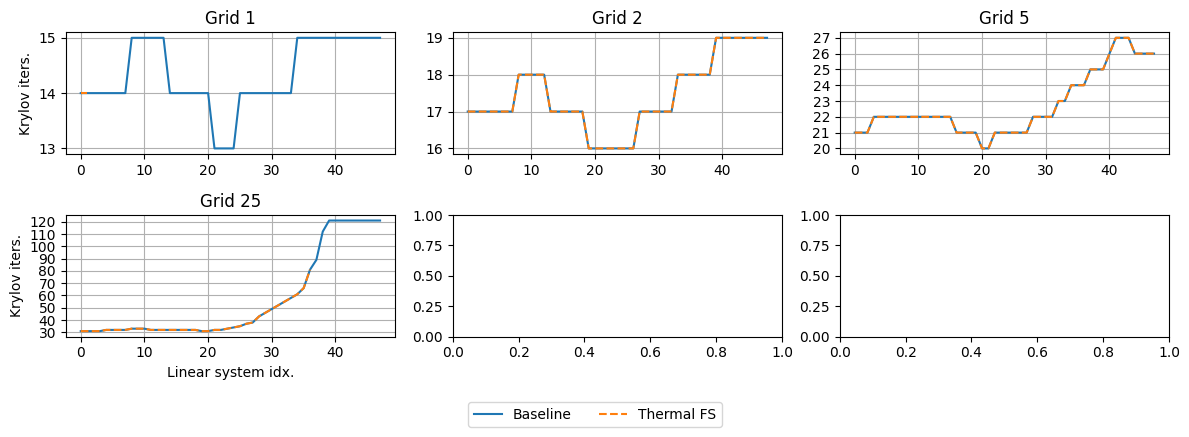

In [3]:
grids = [
    1,
    2,
    5,
    25,
    # 33,
    # 40,
]

sol = [3,4]

data = {}
names = {}
for i, g in enumerate(grids):
    data[i] = []
    for j, s in enumerate(sol):
        data[i].append(load_data(f"../stats/stats_thermal_geonofracx{g}_sol{s}.json"))
        names[i] = f"Grid {g}"


shape = [2, 3]
figsize = (12, 4)


def render_element(i, data):
    plt.gca().grid(True)
    set_integer_ticks("vertical")
    plt.plot(get_gmres_iterations(data[0]), label='Baseline')
    plt.plot(get_gmres_iterations(data[1]), label='Thermal FS', linestyle='--')


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

In [3]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal_runscript_nofrac import make_model
import porepy as pp

model = make_model(
    {
        "geometry": "nofrac",
        "grid_refinement": 5,
        "solver": 4,
        "save_matrix": False,
        "steady_state": False,
        "initial_state": "/home/porepy/volume/nrec_fhm/stats_thermal_geonofracx5_sol3_endstate_1738674820968.npy",
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.00e+00, Dt: 1.00e-03 (days)
Temperature: 393.00, 393.00


/home/porepy/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/porepy/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


sticking: 0, sliding: 0, open: 0


In [4]:
f"../stats/{model.simulation_name()}.json"

'../stats/stats_thermal_geonofracx5_sol4.json'

In [5]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    # '../stats/stats_thermal_geonofracx1_sol4_1738425817582.json'
    # load_data(),
    load_data(f"../stats/{model.simulation_name()}.json"),
    40,
)

In [232]:
model.linear_system = mat, rhs
model.bmat.mat = mat
model.equation_system.set_variable_values(state, time_step_index=0)
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.ad_time_step.set_value(dt)
model.time_manager.dt = dt
model.discretize()

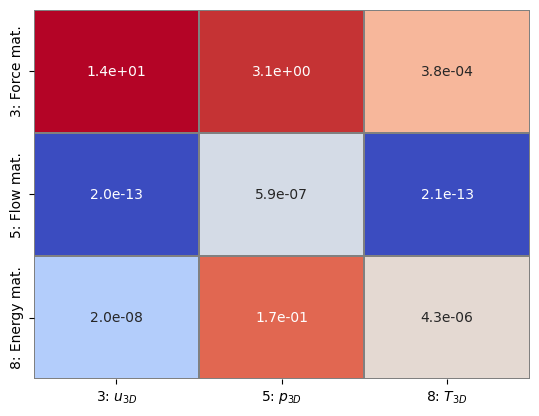

In [233]:
J = model.bmat[:]
J.plot_max()

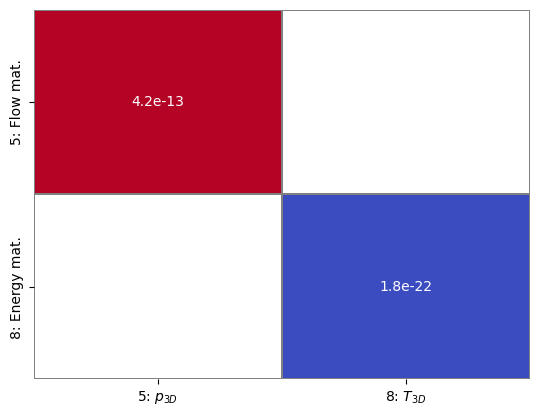

In [234]:
from fixed_stress import (
    get_fixed_stress_stabilization,
    make_fs_analytical,
    make_fs_thermal,
)
from mat_utils import *
from block_matrix import *


def make_stab(bmat: BlockMatrixStorage, keep: list[int], elim: list[int]):
    stab = bmat[keep].empty_container()
    inv_ = inv_block_diag(bmat[elim].mat, nd=model.nd)
    stab.mat -= bmat[keep, elim].mat @ inv_ @ bmat[elim, keep].mat
    return stab


# elim = [0, 1, 2, 3, 4]
# keep = [5, 6, 8, 9]
p = [5]
T = [8]
elim = [3]
keep = p + T
# stab1 = make_stab(J, elim=elim, keep=keep)
# stab1.set_zeros(p, p)
# stab1.set_zeros(p, T)
# stab1.set_zeros(T, p)
# stab1.set_zeros(T, T)

stab1 = make_fs_thermal(
    model,
    J,
    groups=keep,
    p_mat_group=5,
    p_frac_group=-1,
    t_mat_group=8,
    t_frac_group=-1,
)
stab1.plot_max()

S = J[keep].copy()
S.mat += stab1.mat

ksp_type richardson
ksp_pc_side left
ksp_rtol 1e-10
ksp_max_it 120
ksp_gmres_cgs_refinement_type refine_ifneeded
ksp_gmres_classicalgramschmidt True
pc_type fieldsplit
pc_fieldsplit_type schur
pc_fieldsplit_schur_precondition user
pc_fieldsplit_schur_fact_type upper
fieldsplit_3-4_ksp_type preonly
fieldsplit_3-4_pc_type hypre
fieldsplit_5-6-7-8-9-10_ksp_type preonly
fieldsplit_3-4_pc_hypre_type boomeramg
fieldsplit_3-4_pc_hypre_boomeramg_strong_threshold 0.6
fieldsplit_3-4_pc_hypre_boomeramg_P_max 1
fieldsplit_3-4_pc_hypre_boomeramg_max_iter 3
fieldsplit_3-4_pc_hypre_boomeramg_cycle_type W
fieldsplit_5-6-7-8-9-10_pc_type composite
fieldsplit_5-6-7-8-9-10_pc_composite_type multiplicative
fieldsplit_5-6-7-8-9-10_pc_composite_pcs fieldsplit,ilu
fieldsplit_5-6-7-8-9-10_sub_0_pc_fieldsplit_type additive
fieldsplit_5-6-7-8-9-10_sub_0_fieldsplit_5-6-7_ksp_type preonly
fieldsplit_5-6-7-8-9-10_sub_0_fieldsplit_5-6-7_pc_type hypre
fieldsplit_5-6-7-8-9-10_sub_0_fieldsplit_5-6-7_pc_hypre_type boom

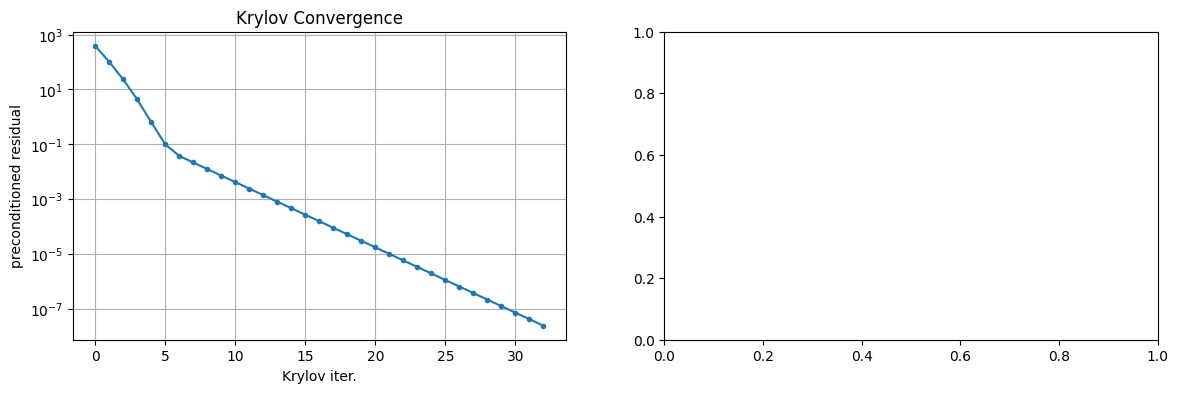

In [263]:
from fixed_stress import make_fs_thermal
from full_petsc_solver import *

self = model
contact = [0]
intf = [1, 2]
mech = [3, 4]
flow = [5, 6, 7]
temp = [8, 9, 10]

scheme = LinearTransformedScheme(
    # right_transformations=[lambda bmat: self.Qright(contact_group=0, u_intf_group=4)],
    inner=PetscKSPScheme(
        petsc_options={
            # "ksp_type": "fgmres",
            'ksp_type': 'richardson',
            'ksp_pc_side': 'left',
            # "ksp_monitor": None,
        },
        preconditioner=PetscFieldSplitScheme(
            groups=mech,
            subsolver_options={
                # 'ksp_type': 'gmres',
                # 'ksp_rtol': 1e-10,
                # 'ksp_pc_side': 'right',
                # # old
                "pc_type": "hypre",
                "pc_hypre_type": "boomeramg",
                "pc_hypre_boomeramg_strong_threshold": 0.6,
                # not sure:
                # "pc_hypre_boomeramg_smooth_type": "Euclid",
                # 'pc_hypre_boomeramg_agg_nl': 3,
                # 'pc_hypre_boomeramg_agg_num_paths': 3,
                # "pc_hypre_boomeramg_truncfactor": 0.8,
                # 'pc_hypre_boomeramg_interp_type': 'ext+i',
                # 'pc_hypre_boomeramg_coarsen_type': 'PMIS',
                "pc_hypre_boomeramg_P_max": 1,
                'pc_hypre_boomeramg_max_iter': 3, 
                'pc_hypre_boomeramg_cycle_type': 'W',
                # vec
                # "pc_hypre_boomeramg_nodal_coarsen": 1,
                # "pc_hypre_boomeramg_vec_interp_variant": 3,
            },
            # tmp_options={
            #     "mat_schur_complement_ainv_type": "blockdiag",
            # },
            block_size=self.nd,
            invert=lambda bmat: csr_to_petsc(
                make_fs_thermal(
                    self,
                    bmat,
                    p_mat_group=5,
                    p_frac_group=-1,
                    t_mat_group=8,
                    t_frac_group=-1,
                    groups=flow + temp,
                ).mat,
                bsize=1,
            ),
            complement=PetscCPRScheme(
                groups=flow + temp,
                pressure_groups=flow,
                pressure_options={
                    "ksp_type": "preonly",
                    "pc_type": "hypre",
                    "pc_hypre_type": "boomeramg",
                },
                others_options={
                    "ksp_type": "preonly",
                    "pc_type": "none",
                },
                cpr_options={
                    # "pc_composite_pcs": "fieldsplit,ksp",
                    # 'sub_1_ksp_ksp_pc_side': 'right',
                    # 'sub_1_ksp_ksp_rtol': 1e-10,
                    "pc_composite_pcs": "fieldsplit,ilu",
                },
            ),
        ),
    ),
)

ksp = solve_petsc_3(J, rhs, scheme, ksp_view=True, options_view=True, return_data=True)